In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import tensorflow as tf
import numpy as np
import glob

BASE_PATH = "/kaggle/input/unet-data/new_data"

# Define folders for train, validation, and test
TRAIN_IMAGES_DIR = os.path.join(BASE_PATH, "train", "images")
TRAIN_MASKS_DIR = os.path.join(BASE_PATH, "train", "GT_TE")

VAL_IMAGES_DIR = os.path.join(BASE_PATH, "valid", "images")
VAL_MASKS_DIR = os.path.join(BASE_PATH, "valid", "GT_TE")

TEST_IMAGES_DIR = os.path.join(BASE_PATH, "test", "images")
TEST_MASKS_DIR = os.path.join(BASE_PATH, "test", "GT_TE")

# Check if files are loaded correctly
print("Train images:", len(os.listdir(TRAIN_IMAGES_DIR)))
print("Train masks:", len(os.listdir(TRAIN_MASKS_DIR)))
print("Validation images:", len(os.listdir(VAL_IMAGES_DIR)))
print("Validation masks:", len(os.listdir(VAL_MASKS_DIR)))
print("Test images:", len(os.listdir(TEST_IMAGES_DIR)))
print("Test masks:", len(os.listdir(TEST_MASKS_DIR)))



IMG_HEIGHT = 256
IMG_WIDTH = 256

def load_image(image_path, mask_path):
    """Load and preprocess a single image-mask pair"""
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_bmp(image, channels=3)  # decode as RGB
    image = tf.image.rgb_to_grayscale(image)        # convert to grayscale
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = tf.cast(image, tf.float32) / 255.0

    # Load mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_bmp(mask, channels=3)
    mask = tf.image.rgb_to_grayscale(mask)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])
    mask = tf.cast(mask, tf.float32) / 255.0
    mask = tf.where(mask > 0.5, 1.0, 0.0)  # binarize

    return image, mask

def create_dataset(image_dir, mask_dir, batch_size=8, shuffle=True):
    """Create tf.data dataset for training, validation, or testing"""
    image_paths = sorted(glob.glob(os.path.join(image_dir, "*.bmp")))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.bmp")))

    print(f"Found {len(image_paths)} images and {len(mask_paths)} masks in {image_dir}")

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=100)

    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)



BATCH_SIZE = 16
train_dataset = create_dataset(TRAIN_IMAGES_DIR, TRAIN_MASKS_DIR, batch_size=BATCH_SIZE)
val_dataset = create_dataset(VAL_IMAGES_DIR, VAL_MASKS_DIR, batch_size=BATCH_SIZE, shuffle=False)
test_dataset = create_dataset(TEST_IMAGES_DIR, TEST_MASKS_DIR, batch_size=1, shuffle=False)


2025-09-15 21:21:52.362235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757971312.545049      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757971312.600624      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Train images: 995
Train masks: 995
Validation images: 25
Validation masks: 25
Test images: 25
Test masks: 25
Found 995 images and 995 masks in /kaggle/input/unet-data/new_data/train/images


I0000 00:00:1757971324.968633      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 25 images and 25 masks in /kaggle/input/unet-data/new_data/valid/images
Found 25 images and 25 masks in /kaggle/input/unet-data/new_data/test/images


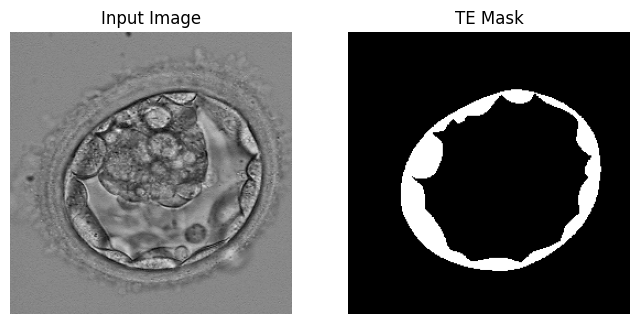

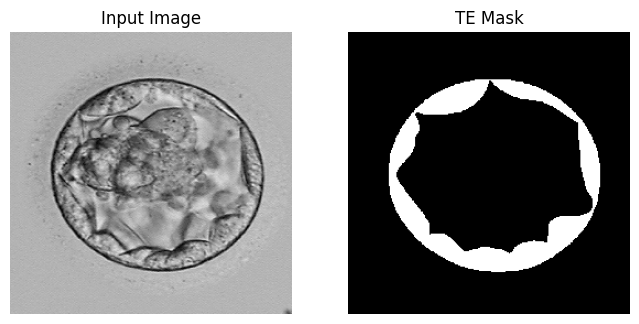

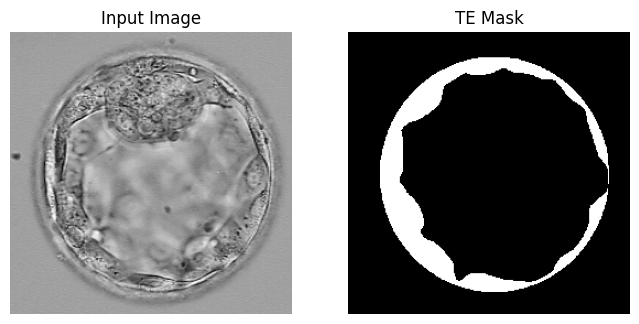

In [6]:
import matplotlib.pyplot as plt

def show_sample(dataset):
    for images, masks in dataset.take(1):
        for i in range(min(3, images.shape[0])):
            plt.figure(figsize=(8, 4))

            plt.subplot(1, 2, 1)
            plt.imshow(tf.squeeze(images[i]), cmap='gray')
            plt.title('Input Image')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(tf.squeeze(masks[i]), cmap='gray')
            plt.title('TE Mask')
            plt.axis('off')

            plt.show()

show_sample(train_dataset)

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def unet_model(input_shape=(256, 256, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer for **binary segmentation**
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    return Model(inputs=[inputs], outputs=[outputs])


In [9]:
# Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# IoU Metric
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# BCE + Dice Loss
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice_loss = 1 - dice_coefficient(y_true, y_pred)
    return bce + dice_loss

In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

EPOCHS = 100
BATCH_SIZE = 16

# Build U-Net model
model = unet_model(input_shape=(256, 256, 1))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=['accuracy', dice_coefficient, iou_metric]
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_dice_coefficient',
    patience=10,
    mode='max',
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor='val_dice_coefficient',
    save_best_only=True,
    mode='max'
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stopping, checkpoint],
    verbose=1   # <-- makes sure metrics are shown
)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 1))
  warnings.warn(msg)
I0000 00:00:1757971373.886094      91 service.cc:148] XLA service 0x7bb3a4024990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757971373.886970      91 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757971374.855251      91 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1757971410.625461      91 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.8799 - dice_coefficient: 0.1738 - iou_metric: 0.0955 - loss: 1.3769

E0000 00:00:1757971434.392007      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757971434.647624      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.8800 - dice_coefficient: 0.1736 - iou_metric: 0.0953 - loss: 1.3752

E0000 00:00:1757971458.378319      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757971458.614567      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757971459.303806      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1757971459.561878      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


63/63 ━━━━━━━━━━━━━━━━━━━━ 101s 883ms/step - accuracy: 0.8801 - dice_coefficient: 0.1734 - iou_metric: 0.0952 - loss: 1.3735 - val_accuracy: 0.8867 - val_dice_coefficient: 0.3093 - val_iou_metric: 0.1830 - val_loss: 0.9180
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 372ms/step - accuracy: 0.8844 - dice_coefficient: 0.3279 - iou_metric: 0.2003 - loss: 0.9652 - val_accuracy: 0.8966 - val_dice_coefficient: 0.5584 - val_iou_metric: 0.3874 - val_loss: 0.6478
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 372ms/step - accuracy: 0.9144 - dice_coefficient: 0.6167 - iou_metric: 0.4468 - loss: 0.5945 - val_accuracy: 0.9314 - val_dice_coefficient: 0.6484 - val_iou_metric: 0.4798 - val_loss: 0.5139
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 372ms/step - accuracy: 0.9295 - dice_coefficient: 0.6696 - iou_metric: 0.5040 - loss: 0.5211 - val_accuracy: 0.9405 - val_dice_coefficient: 0.6867 - val_iou_metric: 0.5229 - val_loss: 0.4592
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 373ms/step - accuracy: 0.9400 - 

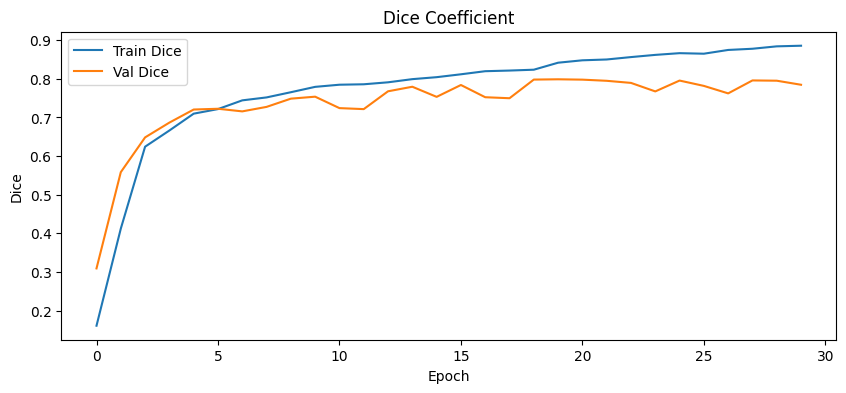

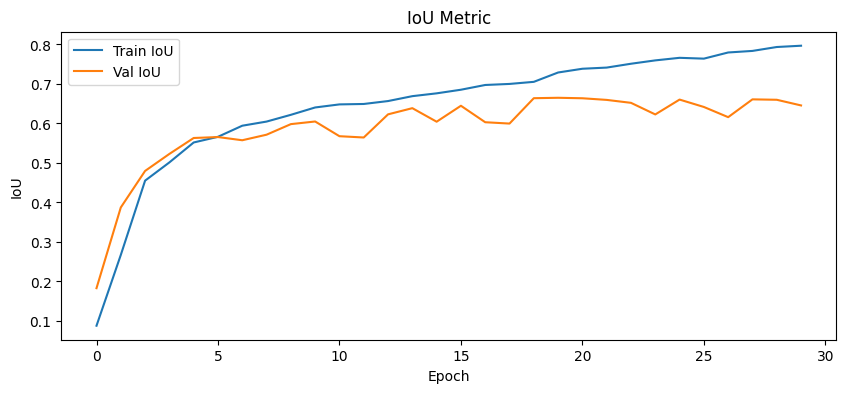

In [12]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    # Dice
    plt.figure(figsize=(10,4))
    plt.plot(history.history['dice_coefficient'], label='Train Dice')
    plt.plot(history.history['val_dice_coefficient'], label='Val Dice')
    plt.title('Dice Coefficient')
    plt.xlabel('Epoch')
    plt.ylabel('Dice')
    plt.legend()
    plt.show()

    # IoU
    plt.figure(figsize=(10,4))
    plt.plot(history.history['iou_metric'], label='Train IoU')
    plt.plot(history.history['val_iou_metric'], label='Val IoU')
    plt.title('IoU Metric')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.show()

plot_metrics(history)

In [13]:
# Load best model
model.load_weights("best_model.h5")

# Evaluate on test set
results = model.evaluate(test_dataset)
print("\nTest Results:")
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9604 - dice_coefficient: 0.7966 - iou_metric: 0.6651 - loss: 0.3083

Test Results:
loss: 0.2953
compile_metrics: 0.9634


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 256, 256, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 874ms/step


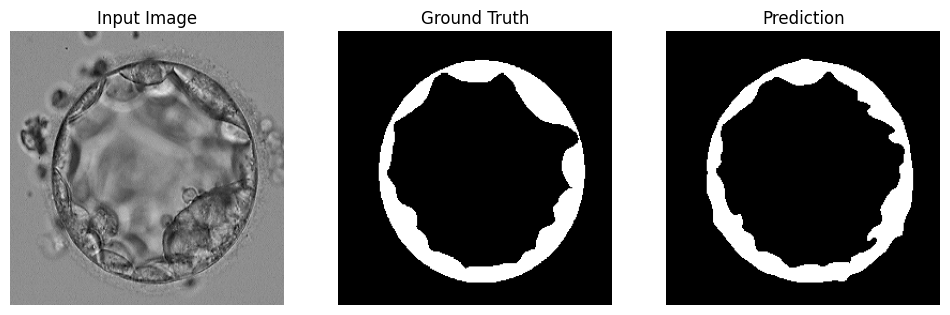

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


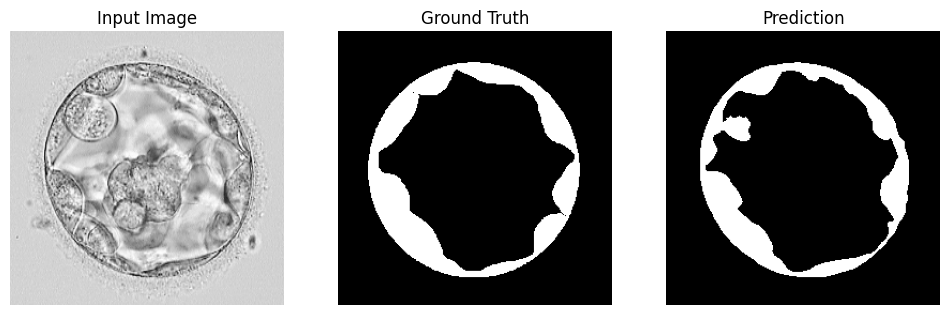

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


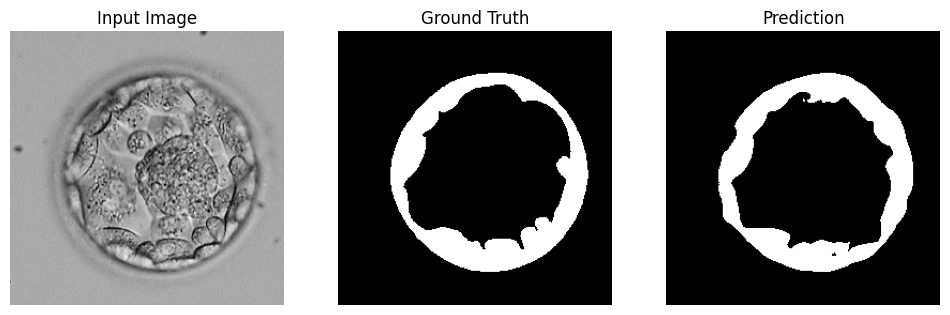

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


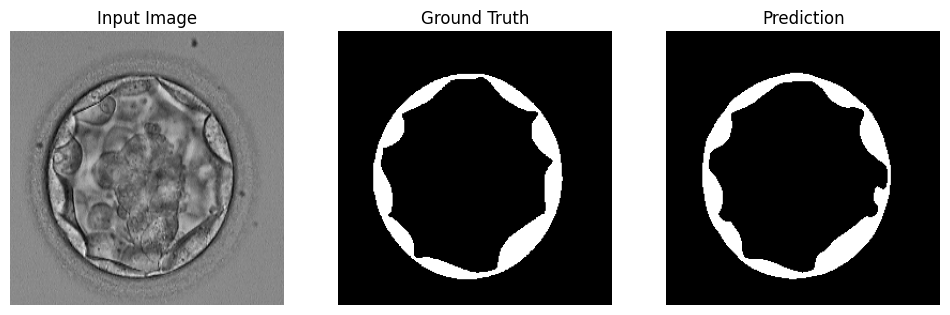

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


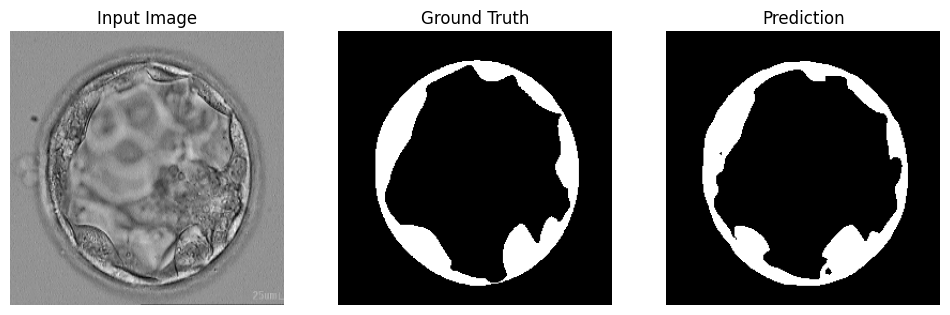

In [14]:
def display_predictions(model, dataset, num_samples=5):
    for images, masks in dataset.take(num_samples):
        preds = model.predict(images)
        preds = (preds > 0.5).astype("float32")  # Binarize predictions

        for i in range(len(images)):
            plt.figure(figsize=(12, 4))

            plt.subplot(1, 3, 1)
            plt.title("Input Image")
            plt.imshow(images[i].numpy().squeeze(), cmap="gray")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.title("Ground Truth")
            plt.imshow(masks[i].numpy().squeeze(), cmap="gray")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.title("Prediction")
            plt.imshow(preds[i].squeeze(), cmap="gray")
            plt.axis("off")

            plt.show()

# Show predictions for test samples
display_predictions(model, test_dataset, num_samples=5)